In [18]:
import os
import sys
import random
import cv2
import math
import time
import numpy as np
import re
import glob

ROOT_DIR = os.path.abspath('../models/Mask_RCNN')
#import mask rcnn
sys.path.append(ROOT_DIR)

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn.model import log

MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [45]:
from sklearn import model_selection

In [25]:
import matplotlib
import matplotlib.pyplot as plt
from mrcnn import visualize
%matplotlib inline 

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [55]:
class SegmentationConfig(Config):
  NAME = "SegmentationConfig"
  IMAGES_PER_GPU = 2
  NUM_CLASSES = 1 + 9 # background + 9
  STEPS_PER_EPOCH = 1000 #1000

class SegmentationDataset(utils.Dataset):
  ALL_CLASSES = [
              ('bicycle', 35),
              ('bicycle_group', 163),
              ('billboard', 86),
              ('bridge', 98),
              ('building', 97),
              ('bus', 39),
              ('bus_group', 167),
              ('car', 33),
              ('car_groups', 161),
              ('dustbin', 85),
              ('fence', 67),
              ('motorbicycle', 34),
              ('motorbicycle_group', 162),
              ('others', 0),
              ('overpass', 100),
              ('person', 36),
              ('person_group', 164),
              ('pole', 82),
              ('rider', 37),
              ('rider_group', 165),
              ('road', 49),
              ('road_pile', 66),
              ('rover', 1),
              ('siderwalk', 50),
              ('sky', 17),
              ('traffic_cone', 65),
              ('traffic_light', 81),
              ('traffic_sign', 83),
              ('tricycle', 40),
              ('tricycle_group', 168),
              ('truck', 38),
              ('truck_group', 166),
              ('tunnel', 99),
              ('vegatation', 113),
              ('wall', 84)
            ]

  MAIN_CLASSES = [33, 35, 39, 40, 36, 65, 34, 38, 37]

  CLASSES = [ c for c in ALL_CLASSES if c[1] in [33, 35, 39, 40, 36, 65, 34, 38, 37] ]
  CLASS_NAME_TO_ID = {}
  CLASS_ID_TO_NAME = {}
  CLASS_OLD_ID_TO_ID = {}
  for i in range( len(CLASSES) ):
      c_name = CLASSES[i][0]
      old_id = CLASSES[i][1]
      new_id = i + 1

      CLASS_NAME_TO_ID[c_name] = { 'id': new_id,   'old_id': old_id }
      CLASS_ID_TO_NAME[new_id] = { 'name': c_name, 'old_id': old_id }
      CLASS_OLD_ID_TO_ID[old_id] = { 'name': c_name, 'id': new_id }

  def load_cvpr_images(self, images_paths):
    # Add classes
    for class_name in self.CLASS_NAME_TO_ID.keys():
      self.add_class("wad", self.CLASS_NAME_TO_ID[class_name]['id'], class_name)

    for i in range(len(images_paths)):
      path = images_paths[i]
      image_name = path.split('/')[-1].split('.')[0]
      self.add_image("wad", image_id=i, path=path, image_name=image_name)

  def load_mask(self, image_id):
    image_name = self.image_info[image_id]['image_name']
    path = "/home/ubuntu/datalab/train_label/"+ image_name +"_instanceIds.png"
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    ids = []

    all_instances = np.unique(image)
    intances_ids = [ int(x/1000) for x in all_instances ]
    intances_ids = np.array([x for x in intances_ids if x in self.MAIN_CLASSES ])

    masks_shape = (image.shape[0], image.shape[1], intances_ids.shape[0])
    masks = np.zeros(masks_shape, dtype=np.bool)

    i_ = 0
    for i in range(all_instances.shape[0]):
      class_id = int(all_instances[i]/1000)
      if self.CLASS_OLD_ID_TO_ID.get(class_id):
        ids.append(self.CLASS_OLD_ID_TO_ID[class_id]['id'])
        masks[:, :, i_] = (image == all_instances[i])
        i_+=1

    ids = np.array(ids, dtype=np.int32)
    return masks, ids


In [56]:
train = glob.glob('/home/ubuntu/datalab/train_color/*.jpg')
X_train, X_val, _, _ = model_selection.train_test_split(train, train, test_size=0.3)
config = SegmentationConfig()
config.display()
dataset_train = SegmentationDataset()
dataset_train.load_cvpr_images(X_train)
dataset_train.prepare()

dataset_val = SegmentationDataset()
dataset_val.load_cvpr_images(X_val)
dataset_val.prepare()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                22
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9

In [57]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [58]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/ubuntu/labs/cvpr/models/Mask_RCNN/logs/segmentationconfig20180530T2121/mask_rcnn_segmentationconfig_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mas

### Inference

In [62]:
class InferenceConfig(SegmentationConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/ubuntu/labs/cvpr/models/Mask_RCNN/logs/segmentationconfig20180530T2121/mask_rcnn_segmentationconfig_0001.h5


In [63]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (22,)                 min:    0.00000  max: 11763.00000  float64
gt_class_id              shape: (11,)                 min:    3.00000  max:    9.00000  int32
gt_bbox                  shape: (11, 4)               min:  617.00000  max: 1014.00000  int32
gt_mask                  shape: (1024, 1024, 11)      min:    0.00000  max:    1.00000  bool


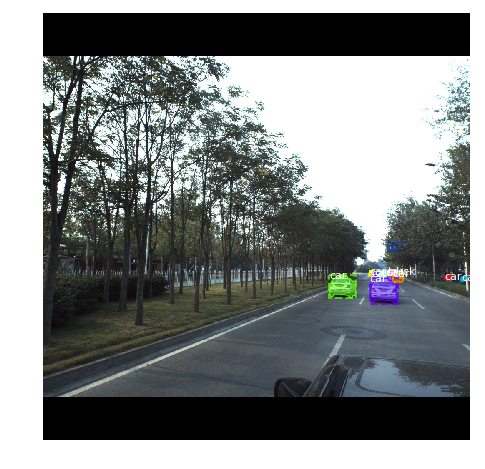

In [64]:
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

### Predict

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


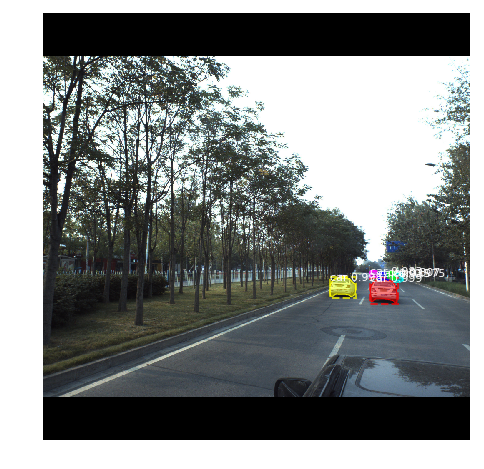

In [65]:
results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [73]:

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.21723375892089236


In [74]:
r["rois"]

array([[ 711,  422,  928,  894],
       [ 685,  826,  748, 1004],
       [ 629,  222,  648,  243],
       [ 647,  507,  679,  569],
       [ 641,  447,  656,  474],
       [ 645,  501,  670,  530],
       [ 643,  503,  654,  530],
       [ 641,  482,  660,  499]], dtype=int32)

In [75]:
r["class_ids"]

array([3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

In [76]:
r["scores"]

array([0.9969446 , 0.9946017 , 0.992332  , 0.83706295, 0.8179433 ,
       0.81449354, 0.7057352 , 0.7026884 ], dtype=float32)